# San Diego Burrito Analytics: Data characterization

Scott Cole

21 May 2016

This notebook characterizes the collection of reviewers of San Diego burritos including:

1. Metadata
2. How many of each kind of burrito have been reviewed?
3. For each of burrito dimension, what is the distribution of its scores across all samples?

### Default imports

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
sns.set_style("white")

### Load data

In [2]:
import util
df = util.load_burritos()
N = df.shape[0]
df.head()

,Location,Burrito,Date,Neighborhood,Address,URL,Yelp,Google,Chips,Cost,...,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
0,donato's taco shop,California,1/18/2016,Miramar,6780 Miramar Rd,http://donatostacoshop.net/,3.5,4.2,None,6.49,...,None,None,None,None,None,None,None,None,None,None
1,oscar's mexican food,California,1/24/2016,San Marcos,225 S Rancho Santa Fe Rd,http://www.yelp.com/biz/oscars-mexican-food-sa...,3.5,3.3,None,5.45,...,None,None,None,None,None,None,None,None,None,None
2,oscar's mexican food,Carnitas,1/24/2016,None,None,None,NaN,NaN,None,4.85,...,None,None,None,None,None,None,None,None,None,None
3,oscar's mexican food,Carne asada,1/24/2016,None,None,None,NaN,NaN,None,5.25,...,None,None,None,None,None,None,None,None,None,None
4,pollos maria,California,1/27/2016,Carlsbad,3055 Harding St,http://pollosmaria.com/,4.0,3.8,x,6.59,...,None,None,None,None,None,None,None,None,None,None


### Brief metadata

In [3]:
print('Number of burritos:', df.shape[0])
print('Number of restaurants:', len(df.Location.unique()))
print('Number of reviewers:', len(df.Reviewer.unique()))
print('Number of reviews by Scott:', df.Reviewer.value_counts()['Scott'])

uniqlocidx = df.Location.drop_duplicates().index
print('Percentage of taco shops with free chips:', np.round(100 - 100*df.Chips[uniqlocidx].isnull().sum()/np.float(len(df.Location.unique())),1))

Number of burritos: 306
Number of restaurants: 73
Number of reviewers: 62
Number of reviews by Scott: 111
Percentage of taco shops with free chips: 26.0


In [4]:
# Count of how many burritos each person has eaten
df['Reviewer'].value_counts()

Scott           111
Emily            47
Ricardo          17
Sage             12
Luis             10
Elynn             8
Richard           8
Brent             8
Erin              6
Marc              4
Hannah            4
Matteo            4
Tom               4
Erik              3
Bankole           3
Aga               2
Jeremy            2
Katie             2
Kelsey            2
Shijia            2
Sankha G          2
Tara              2
Devleena          2
Mike              2
Cris              2
Jaeyoung          1
Alex              1
Justin K          1
Javier            1
Benni             1
               ... 
TJ                1
Andy              1
Ant               1
Clark             1
@danjlurie        1
Matt              1
@synapticlee      1
Nihal             1
Justin C          1
Sam A             1
Rob               1
Melissa G         1
Nicole            1
Dan               1
Brad P            1
Spencer           1
Shreejoy          1
Sandra            1
Jake              1


### What types of burritos have been rated?

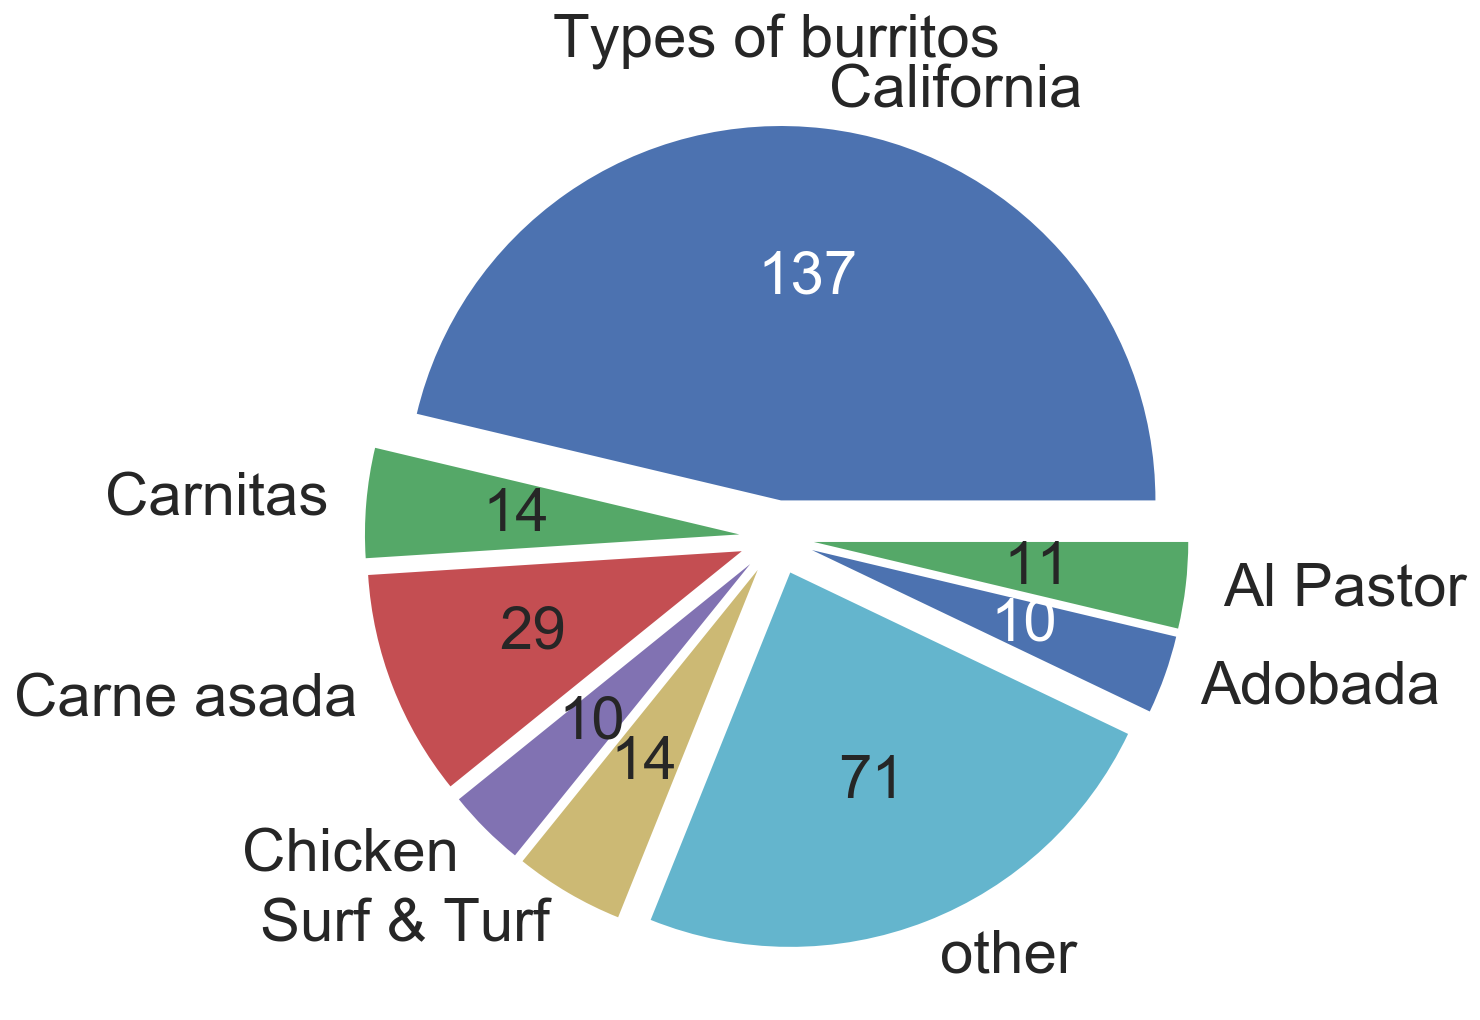

In [61]:
# Number of each type of burrito
def burritotypes(x, types = {'California':'cali', 'Carnitas':'carnita', 'Carne asada':'carne asada',
                             'Chicken':'chicken', 'Surf & Turf':'surf.*turf', 'Adobada':'adobad', 'Al Pastor':'pastor'}):
    import re
    T = len(types)
    Nmatches = {}
    for b in x:
        matched = False
        for t in types.keys():
            re4str = re.compile('.*'+types[t]+'.*', re.IGNORECASE)
            if np.logical_and(re4str.match(b) is not None, matched is False):
                try:
                    Nmatches[t] +=1
                except KeyError:
                    Nmatches[t] = 1
                matched = True
        if matched is False:
            try:
                Nmatches['other'] +=1
            except KeyError:
                Nmatches['other'] = 1
    return Nmatches

typecounts = burritotypes(df.Burrito)

plt.figure(figsize=(10,10))
ax = plt.axes([0.1, 0.1, 0.65, 0.65])

# The slices will be ordered and plotted counter-clockwise.
labels = typecounts.keys()
fracs = np.array([i for i in typecounts.values()])
explode=[.1]*len(typecounts)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda p: '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=0)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Types of burritos',size=30)
for t in texts:
    t.set_size(30)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[6].set_color('w')

figname = 'burritotypes'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

### Progress in number of burritos rated

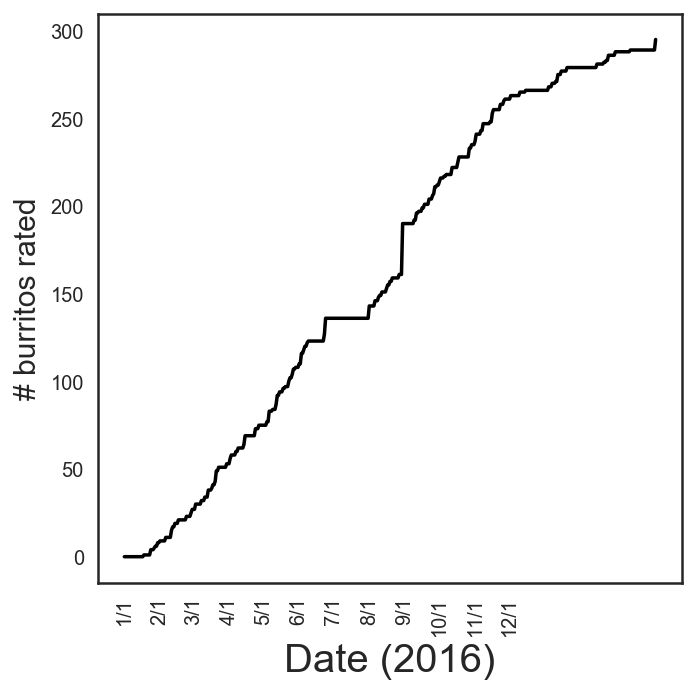

In [35]:
# Time series of ratings
import math

def dates2ts(dates):
    from datetime import datetime
    
    D = len(dates)
    start = datetime.strptime('1/1/2016','%m/%d/%Y')
    ts = np.zeros(D,dtype=int)
    for d in range(D):
        burrdate = datetime.strptime(df.Date[d],'%m/%d/%Y')
        diff = burrdate - start
        ts[d] = diff.days
    return ts

def cumburritos(days):
    from statsmodels.distributions.empirical_distribution import ECDF
    ecdf = ECDF(days)
    t = np.arange(days[-1]+1)
    return t, ecdf(t)*len(days)

def datelabels(startdate = '1/1/2016', M = 12):
    from datetime import datetime
    start = datetime.strptime(startdate,'%m/%d/%Y')
    datestrs = []
    ts = np.zeros(M)
    for m in range(M):
        datestrs.append(str(m+1) + '/1')
        burrdate = datetime.strptime(datestrs[m]+'/2016','%m/%d/%Y')
        diff = burrdate - start
        ts[m] = diff.days
    return datestrs, ts

burrdays = dates2ts(df.Date)
t, burrcdf = cumburritos(burrdays)
datestrs, datets = datelabels()

plt.figure(figsize=(5,5))
plt.plot(t,burrcdf,'k-')
plt.xlabel('Date (2016)',size=20)
plt.ylabel('# burritos rated',size=15)
plt.xticks(datets,datestrs,size=10, rotation='vertical')
plt.yticks(size=10)
plt.tight_layout()

figname = 'burritoprogress'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

# Burrito dimension distributions

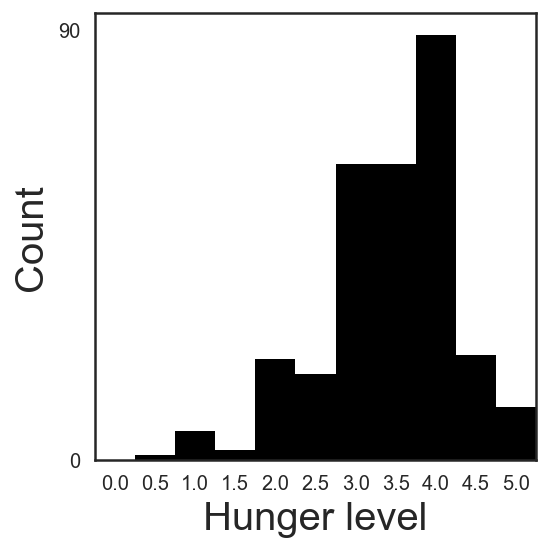

In [37]:
# Distribution of hunger level
plt.figure(figsize=(4,4))
n, _, _ = plt.hist(df.Hunger.dropna(),np.arange(-.25,5.5,.5),color='k')
plt.xlabel('Hunger level',size=20)
plt.xticks(np.arange(0,5.5,.5),size=10)
plt.xlim((-.25,5.25))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=10)
plt.tight_layout()

figname = 'hungerleveldist'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

6.8726369863


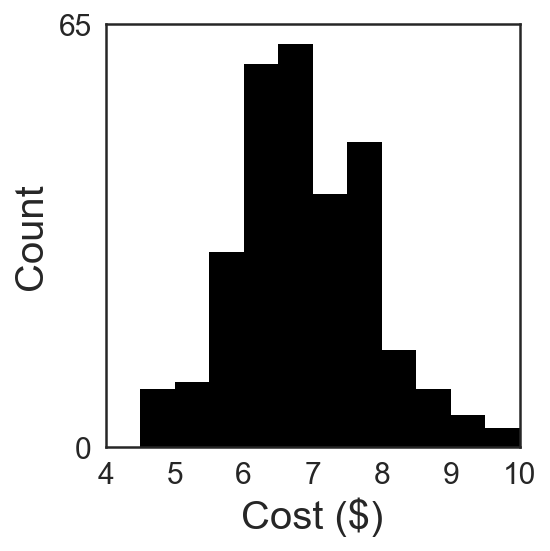

In [39]:
# Average burrito cost
plt.figure(figsize=(4,4))
n, _, _ = plt.hist(df.Cost.dropna(),np.arange(4,10.25,.5),color='k')
plt.xlabel('Cost ($)',size=20)
plt.xticks(np.arange(4,11,1),size=15)
plt.xlim((4,10))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'costdist'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

print(np.nanmean(df.Cost))

0.7746842105263158


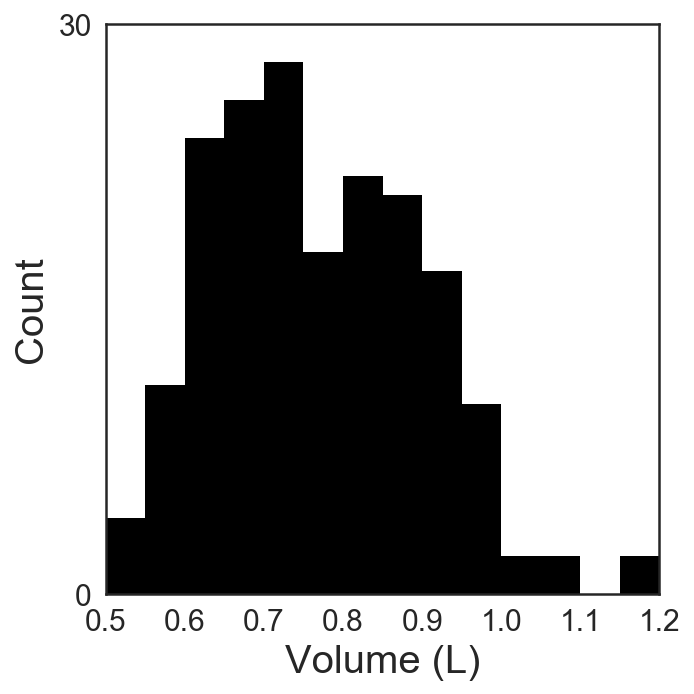

In [40]:
# Volume dist
plt.figure(figsize=(5,5))
n, _, _ = plt.hist(df.Volume.dropna(),np.arange(0.5,1.3,.05),color='k')
plt.xlabel('Volume (L)',size=20)
plt.xticks(np.arange(0.5,1.3,.1),size=15)
plt.xlim((0.5,1.2))
plt.ylabel('Count',size=20)
plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
plt.tight_layout()

figname = 'volumedist'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

print(np.mean(df.Volume))

In [41]:
def metrichist(metricname):
    plt.figure(figsize=(5,5))
    n, _, _ = plt.hist(df[metricname].dropna(),np.arange(-.25,5.5,.5),color='k')
    plt.xlabel(metricname + ' rating',size=20)
    plt.xticks(np.arange(0,5.5,.5),size=15)
    plt.xlim((-.25,5.25))
    plt.ylabel('Count',size=20)
    plt.yticks((0,int(math.ceil(np.max(n) / 5.)) * 5),size=15)
    plt.tight_layout()
    
    if metricname == 'Meat:filling':
        metricname = 'meattofilling'
    figname = metricname + 'dist'
    plt.savefig('/gh/fig/burrito/'+figname + '.png')

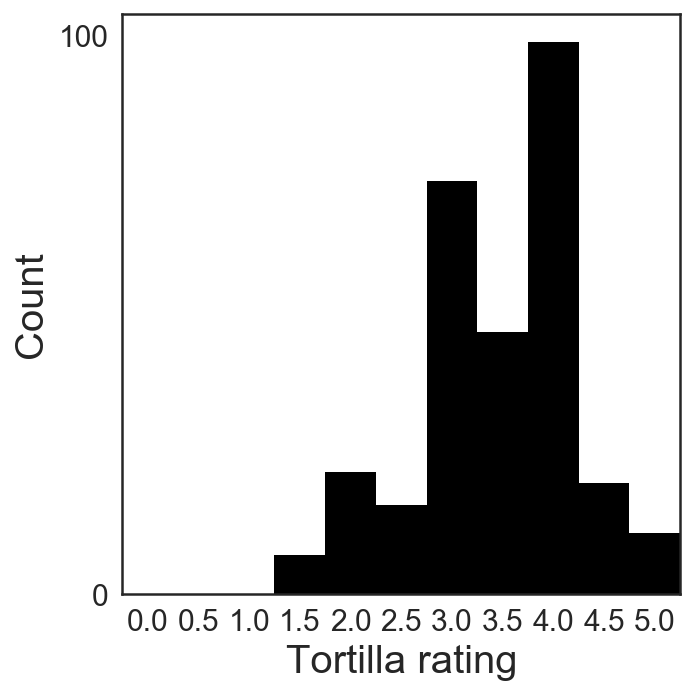

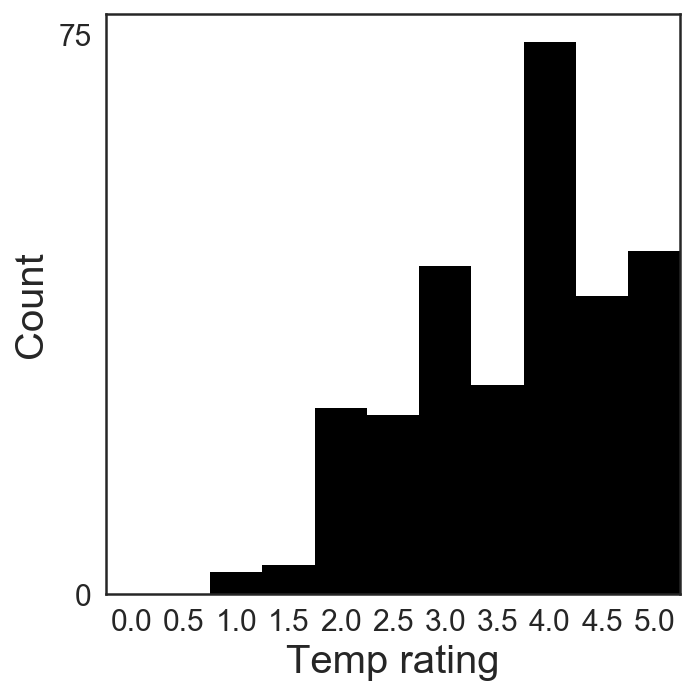

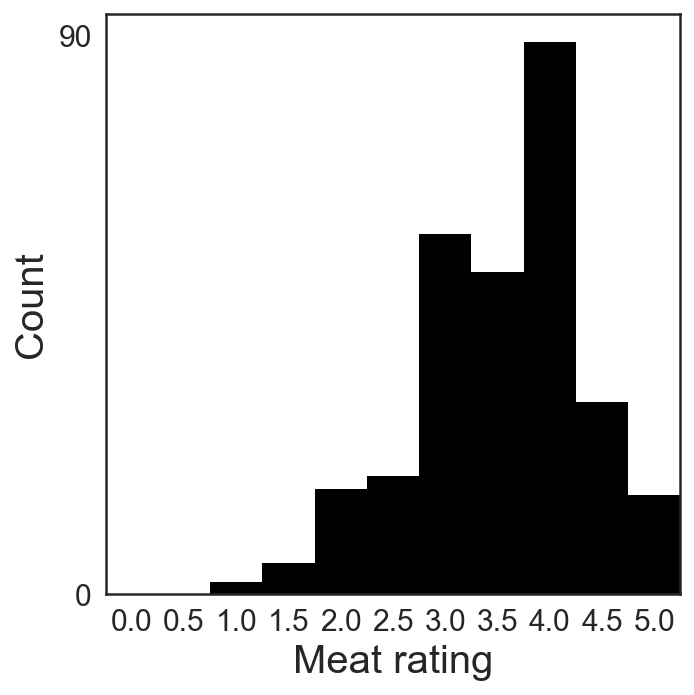

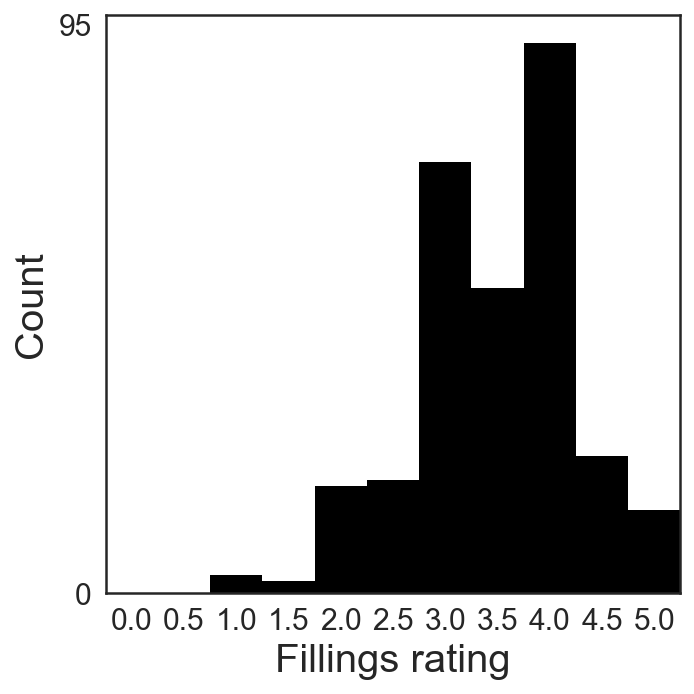

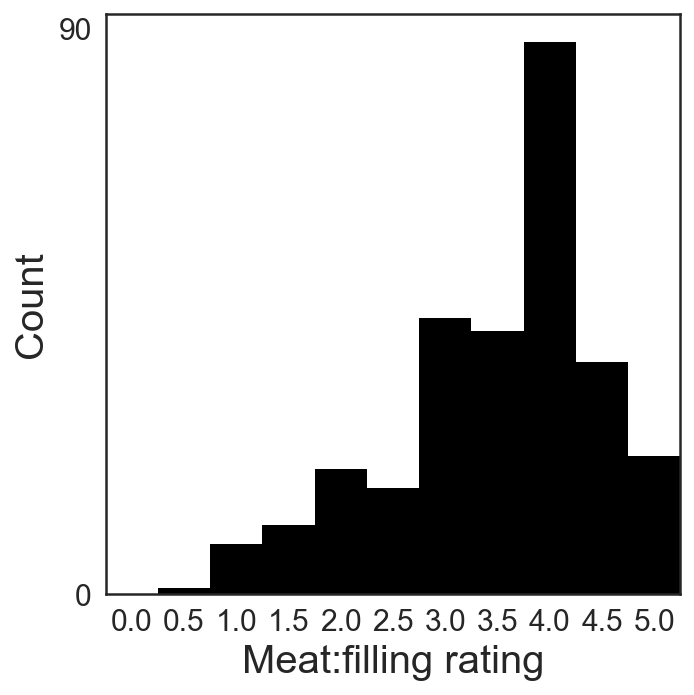

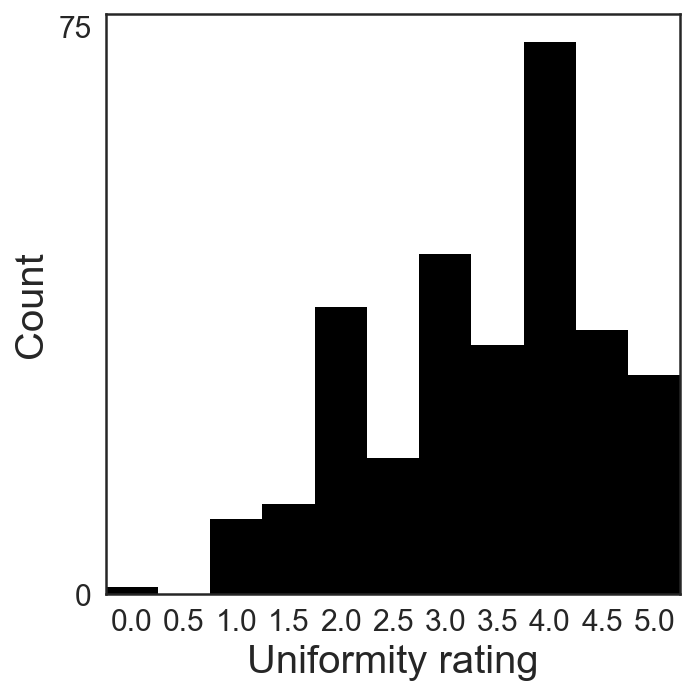

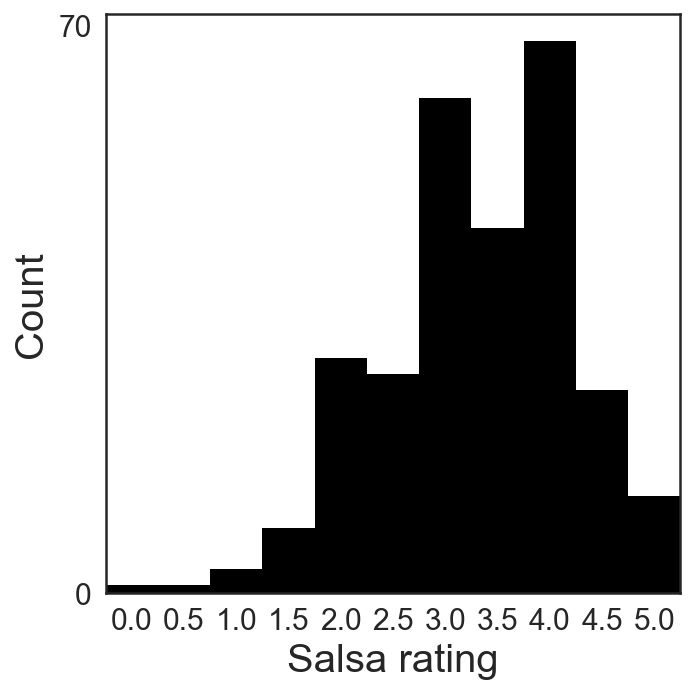

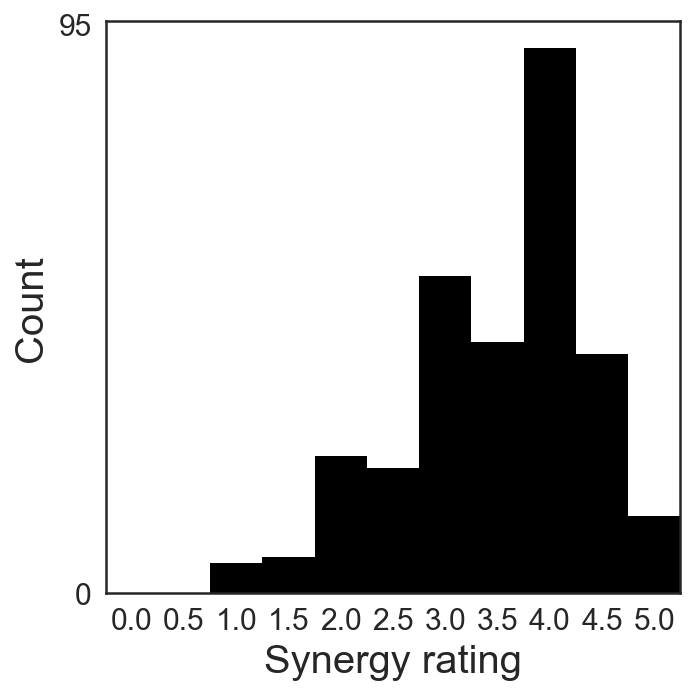

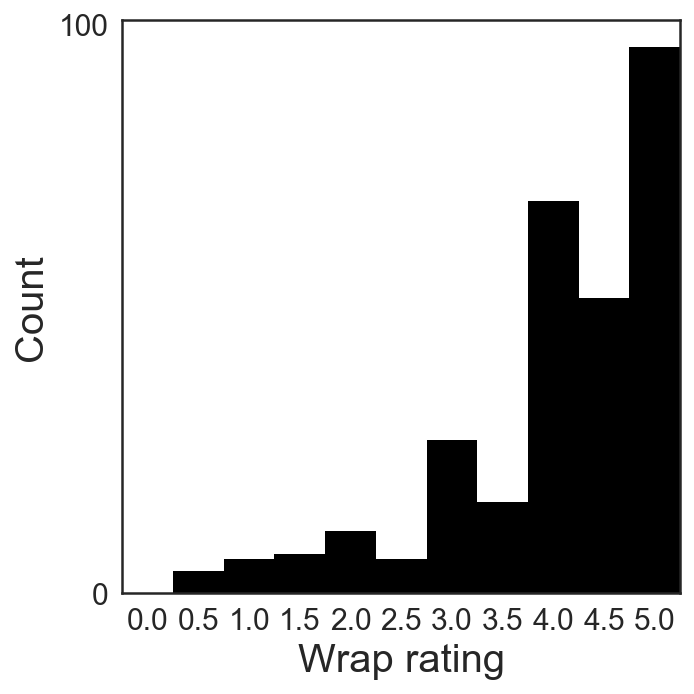

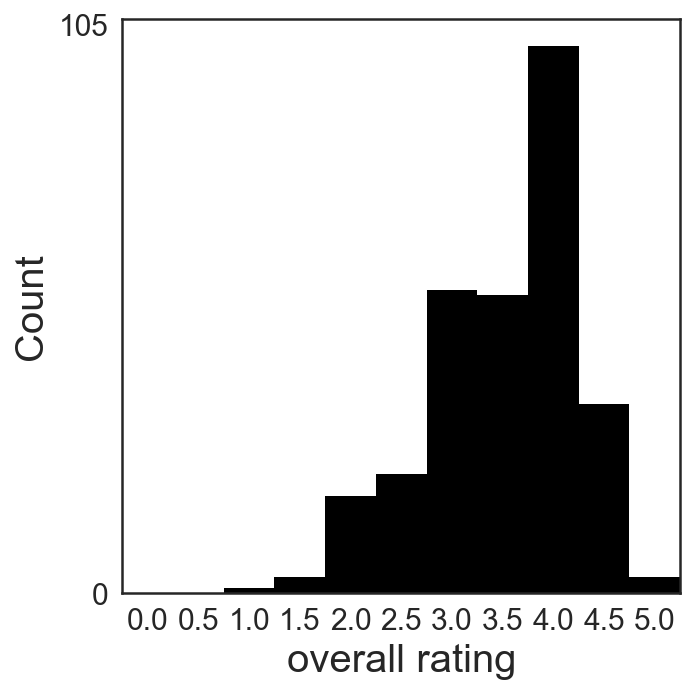

In [42]:
m_Hist = ['Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap','overall']
for m in m_Hist:
    metrichist(m)

# Fraction of burritos recommended

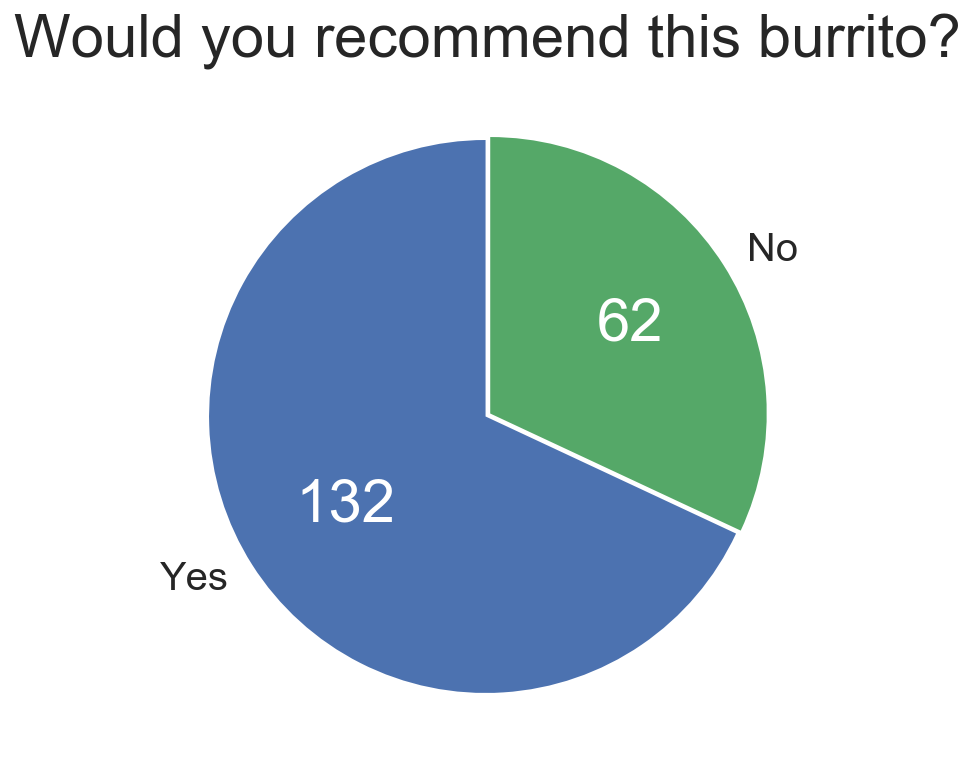

In [44]:
# Overall recommendations
plt.figure(figsize=(6,6))
ax = plt.axes([0.1, 0.1, 0.8, 0.8])

# The slices will be ordered and plotted counter-clockwise.
labels = ['Yes','No']
fracs = np.array([np.sum(df.Rec==labels[0]),np.sum(df.Rec==labels[1])])
explode=[.01]*len(labels)

patches, texts, autotexts = plt.pie(fracs, explode=explode, labels=labels,
                autopct=lambda p: '{:.0f}'.format(p * np.sum(fracs) / 100), shadow=False, startangle=90)
                # The default startangle is 0, which would start
                # the Frogs slice on the x-axis.  With startangle=90,
                # everything is rotated counter-clockwise by 90 degrees,
                # so the plotting starts on the positive y-axis.

plt.title('Would you recommend this burrito?',size=30)
for t in texts:
    t.set_size(20)
for t in autotexts:
    t.set_size(30)
autotexts[0].set_color('w')
autotexts[1].set_color('w')

figname = 'recspie'
plt.savefig('/gh/fig/burrito/'+figname + '.png')

# PCA

In [45]:
dfpca = df[['Volume','Tortilla','Temp','Meat','Fillings','Meat:filling','Uniformity','Salsa','Synergy','Wrap']]

In [46]:
dfpca = dfpca.fillna(dfpca.mean())

In [47]:
# Normalize
dfpca = (dfpca - dfpca.mean()) / dfpca.std()
dfpca

,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap
0,-9.088697e-15,-0.576146,1.368567e+00,-0.662901,2.312415e-02,5.121340e-01,5.661541e-01,7.806461e-01,5.754711e-01,-0.020867
1,-9.088697e-15,-1.856951,-1.666731e-01,-1.279902,-1.247624e+00,-1.524882e+00,5.661541e-01,2.208998e-01,-1.114724e+00,0.908680
2,-9.088697e-15,-0.576146,-1.701913e+00,-1.279902,-6.122498e-01,1.021388e+00,5.661541e-01,-3.388464e-01,-5.513255e-01,0.908680
3,-9.088697e-15,-0.576146,-1.701913e+00,-0.045901,-6.122498e-01,5.121340e-01,1.482221e+00,7.806461e-01,5.754711e-01,0.908680
4,-9.088697e-15,0.704659,1.368567e+00,0.571099,2.312415e-02,1.021388e+00,1.482221e+00,-8.985926e-01,1.138869e+00,-0.020867
5,-9.088697e-15,-0.576146,3.450737e-01,1.805099,2.312415e-02,-1.015628e+00,-8.079458e-01,-8.985926e-01,5.754711e-01,-2.809511
6,-9.088697e-15,-1.856951,-6.784198e-01,-0.662901,-1.882998e+00,-1.015628e+00,-8.079458e-01,-9.943090e-16,-1.678122e+00,-0.950415
7,-9.088697e-15,-1.216548,-6.784198e-01,-0.662901,-1.247624e+00,-5.063741e-01,1.081208e-01,-9.943090e-16,-1.114724e+00,-0.950415
8,-9.088697e-15,-1.856951,8.568204e-01,1.188099,2.312415e-02,-2.034136e+00,-3.499125e-01,2.208998e-01,5.754711e-01,-1.879963
9,-9.088697e-15,-1.216548,-2.213660e+00,-2.513902,-6.122498e-01,1.021388e+00,-3.499125e-01,-2.018085e+00,-1.678122e+00,0.443906


In [48]:
# Color: Taco Stand, Lucha, Los Primos

In [50]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(dfpca)
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.05968986 -0.29314011 -0.16876168 -0.40408419 -0.41591497 -0.35206131
  -0.30528377 -0.30817118 -0.47054823 -0.1105701 ]
 [ 0.58282711 -0.0219306  -0.32033962  0.18117511  0.25283711 -0.23158705
  -0.28799319  0.0595622   0.1263049  -0.55171541]]
[ 0.31745864  0.13422862]


In [52]:
dfpca_proj = np.dot(pca.components_,dfpca.T)

In [55]:
dfpca_proj[0][np.where(df.Location=='taco stand')]

array([-0.80742316, -2.00131199, -1.35613596, -0.9917251 , -2.06755343,
       -0.4534122 , -0.94989751, -0.71945859, -3.76620568, -1.12303123,
       -2.78293179, -0.37042261, -1.13248002, -2.1988757 , -0.56059913,
       -1.0268796 , -0.18705229, -0.92969333, -0.69636664, -3.35478032,
       -3.05930692])

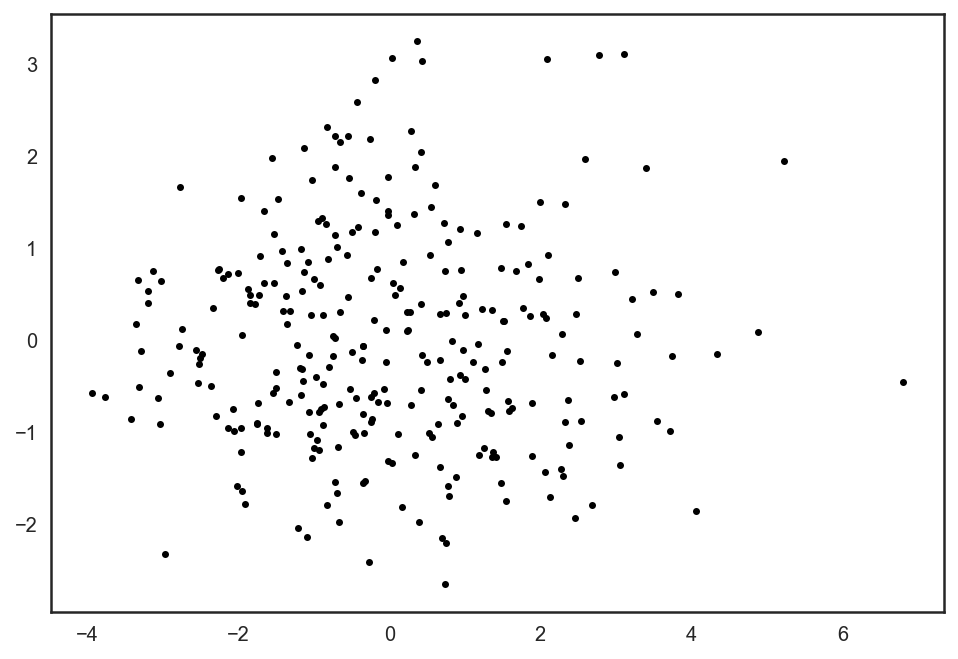

In [56]:
plt.plot(dfpca_proj[0],dfpca_proj[1],'k.')

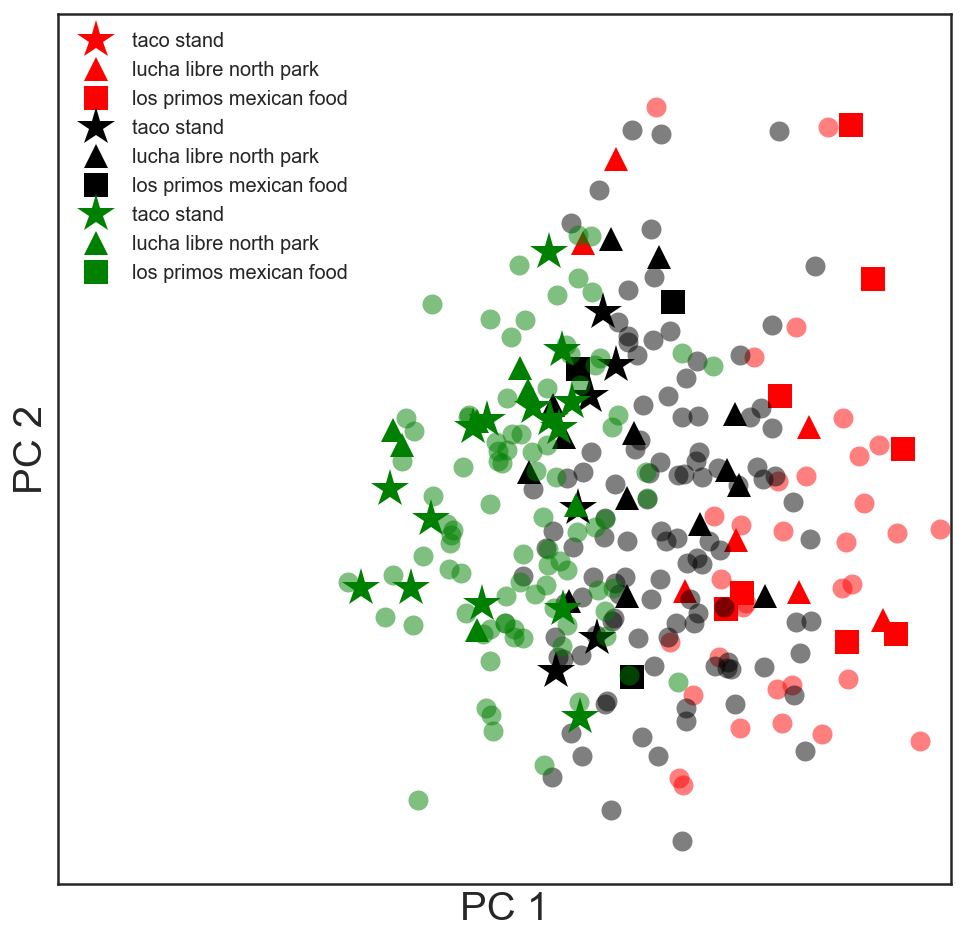

In [57]:
plt.figure(figsize=(8,8))
shops = ['taco stand','lucha libre north park','los primos mexican food']
shops_marker = ['*','^','s']
shops_ms = [20,12,12]
overallcutoffs = [-.1, 3, 4, 5.1]
overallcolors = ['r','k','g']


for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))
    plt.plot(dfpca_proj[0][notshops],dfpca_proj[1][notshops],'.',color=overallcolors[o],alpha=.5,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))
        plt.plot(dfpca_proj[0][burridx],dfpca_proj[1][burridx],
                 shops_marker[s],color=overallcolors[o],ms=shops_ms[s],label = shops[s])
plt.xlim((-8,4.5))
plt.ylim((-3,4))
plt.xlabel('PC 1',size=20)
plt.ylabel('PC 2',size=20)
plt.xticks([])
plt.yticks([])
plt.legend(loc='best')

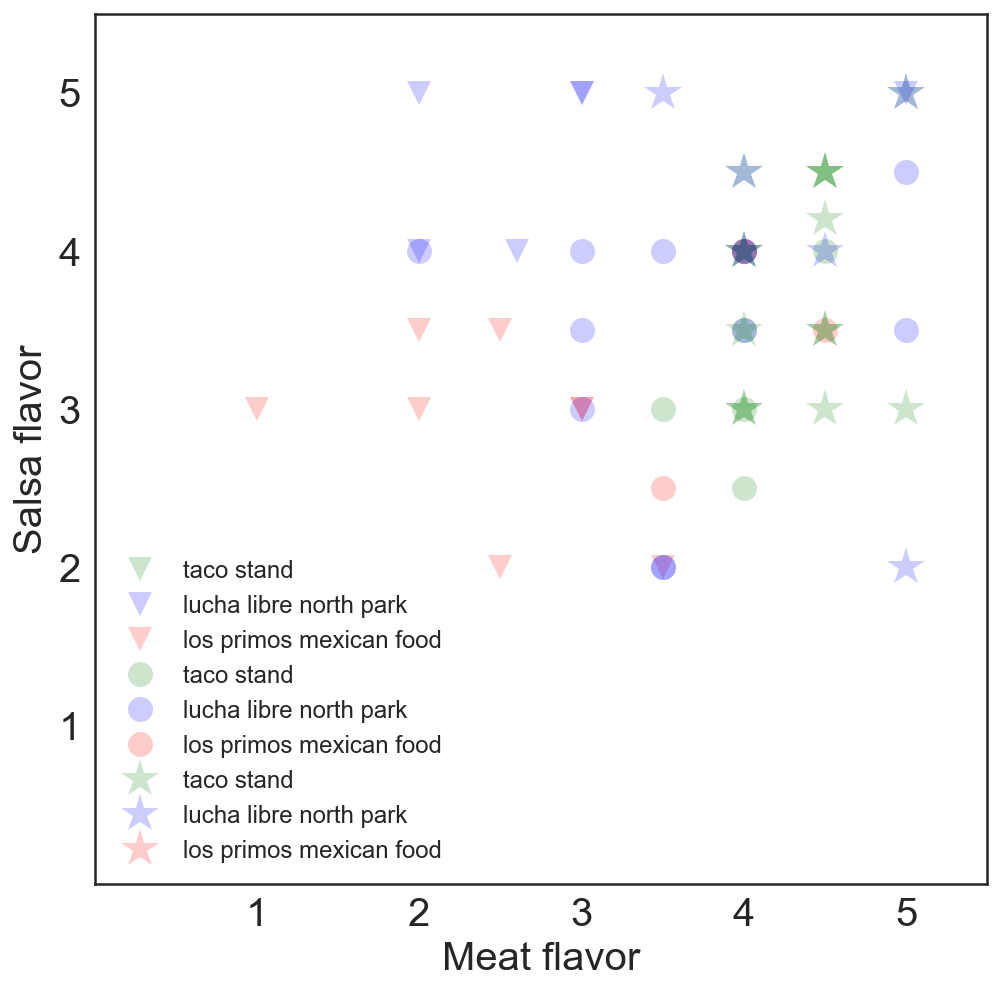

In [59]:
shopsalpha = [.2,.2,.2]
shops = ['taco stand','lucha libre north park','los primos mexican food']
overall_marker = ['v','.','*']
overall_ms = [12,25,20]
overallcutoffs = [-.1, 3, 4, 5.1]
shopscolors = ['g','b','r']

plt.figure(figsize=(8,8))
for o in range(len(overallcolors)):
    notshops = np.logical_and(df.Location != shops[0],np.logical_and(df.Location != shops[1],df.Location != shops[2]))
    orange = np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])
    notshops = np.where(np.logical_and(notshops,orange))[0]
    #plt.plot(df.Meat[notshops],df.Fillings[notshops],'.',color=overallcolors[o],alpha=.2,ms=20)
    for s in range(len(shops)):
        burridx = np.where(np.logical_and(df.Location==shops[s],np.logical_and(df.overall>=overallcutoffs[o],df.overall<overallcutoffs[o+1])))[0]
        plt.plot(df.Meat[burridx],df.Salsa[burridx],
                 overall_marker[o],color=shopscolors[s],ms=overall_ms[o],alpha=shopsalpha[s],label=shops[s])
plt.xlim((0,5.5))
plt.ylim((0,5.5))
plt.xlabel('Meat flavor',size=20)
plt.ylabel('Salsa flavor',size=20)
plt.xticks(np.arange(1,6),size=20)
plt.yticks(np.arange(1,6),size=20)
plt.legend(loc='best',fontsize=12)

plt.savefig('/gh/fig/burrito/superscatter.png')